In [3]:
#setting env and install packages
!pip install -q condacolab 
import condacolab
condacolab.install()
# install scglue with GPU support
!mamba install -y -c conda-forge -c bioconda scglue pytorch-gpu bedtools scikit-misc anndata >/dev/null 

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


In [1]:
 #mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import itertools
import pandas as pd
import seaborn as sns
import anndata as ad
import networkx as nx
import scglue
import scanpy as sc
import numpy as np
from matplotlib import rcParams
from itertools import chain

scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [2]:
#load the data 
adata_atac_set1 = sc.read_10x_mtx("drive/MyDrive/work/single_cell_analysis_demo/process/ccRCC_ATAC_set1")
adata_rna_set1 = sc.read_10x_h5("drive/MyDrive/work/single_cell_analysis_demo/process/GSM4572192_Control1_filtered_feature_bc_matrix.h5")
adata_rna_set1.var_names_make_unique()

/usr/local/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
#backup raw counts 
adata_rna_set1.layers["counts"] = adata_rna_set1.X.copy()

In [4]:
#select hv genes
sc.pp.highly_variable_genes(adata_rna_set1,
                            n_top_genes=2000, 
                            flavor="seurat_v3")

In [5]:
#normalize the dataset and calculate the PCs
sc.pp.normalize_total(adata_rna_set1)
sc.pp.log1p(adata_rna_set1)
sc.pp.scale(adata_rna_set1)
sc.tl.pca(adata_rna_set1, n_comps=100, svd_solver="auto")

In [6]:
#calculate LSI for atac-seq data
scglue.data.lsi(adata_atac_set1, n_components=100, n_iter=15)

In [7]:
#load gencode gtf for gene annotation
scglue.data.get_gene_annotation(
    adata_rna_set1, 
    gtf="drive/MyDrive/work/single_cell_analysis_demo/process/gencode.v41.annotation.gtf.gz",
    gtf_by="gene_name"
)

In [8]:
#remove genes without coordinate defined
adata_rna_set1 = adata_rna_set1[:, ~adata_rna_set1.var['chrom'].isnull()]

In [9]:
#define the coordinate for atac-seq data
coor=adata_atac_set1.var_names.str.split(r"[:-]")
adata_atac_set1.var["chrom"] = coor.map(lambda x: x[0])
adata_atac_set1.var["chromStart"] = coor.map(lambda x: x[1]).astype(int)
adata_atac_set1.var["chromEnd"] = coor.map(lambda x: x[2]).astype(int)

In [10]:
#guide regulatory graph construction and verification
guidance = scglue.genomics.rna_anchored_guidance_graph(adata_rna_set1, adata_atac_set1)
scglue.graph.check_graph(guidance, [adata_rna_set1, adata_atac_set1])

window_graph:   0%|          | 0/22695 [00:00<?, ?it/s]

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [11]:
#subset the guidance graph for high variable nodes only
guidance_hvf = guidance.subgraph(chain(
    adata_rna_set1.var.query("highly_variable").index,
    adata_atac_set1.var.query("highly_variable").index
)).copy()

In [12]:
#config the datasets for model training
adata_atac_set1.var_names_make_unique()
adata_rna_set1.var_names_make_unique()

scglue.models.configure_dataset(
    adata_rna_set1, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca"
)
scglue.models.configure_dataset(
    adata_atac_set1, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [ ]:
#train the glue model
glue = scglue.models.fit_SCGLUE(
    {"rna": adata_rna_set1, "atac": adata_atac_set1}, guidance_hvf,
    fit_kws={"directory": "glue"}
)

In [13]:
#save/load the trained model
#glue.save("drive/MyDrive/work/single_cell_analysis_demo/process/glue_set1.dill")
glue = scglue.models.load_model("drive/MyDrive/work/single_cell_analysis_demo/process/glue_set1.dill")

[INFO] autodevice: Using CPU as computation device.


[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 49 common metacells...


/usr/local/lib/python3.7/site-packages/scglue/data.py:626: RuntimeWarning: invalid value encountered in double_scalars
  for s, t in zip(source, target)


[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 99 common metacells...


/usr/local/lib/python3.7/site-packages/scglue/data.py:626: RuntimeWarning: invalid value encountered in double_scalars
  for s, t in zip(source, target)


[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 197 common metacells...


/usr/local/lib/python3.7/site-packages/scglue/data.py:626: RuntimeWarning: invalid value encountered in double_scalars
  for s, t in zip(source, target)


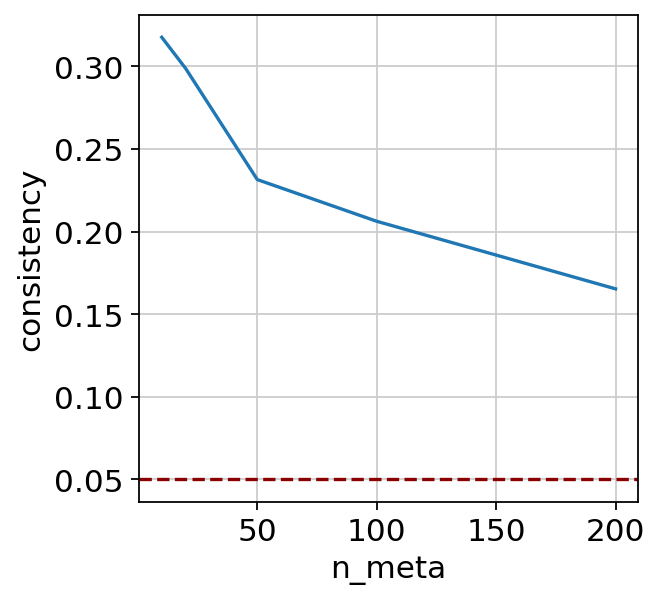

In [16]:
#check the consistancy as a function of metacell size
dx = scglue.models.integration_consistency(
    glue, {"rna": adata_rna_set1, "atac": adata_atac_set1}, guidance_hvf
)
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")


In [14]:
#obtain the aligned latent embeddings
adata_rna_set1.obsm["X_glue"] = glue.encode_data("rna", adata_rna_set1)
adata_atac_set1.obsm["X_glue"] = glue.encode_data("atac", adata_atac_set1)

In [15]:
#obtain the graph as embeddings
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)

adata_rna_set1.varm["X_glue"] = feature_embeddings.reindex(adata_rna_set1.var_names).to_numpy()
adata_atac_set1.varm["X_glue"] = feature_embeddings.reindex(adata_atac_set1.var_names).to_numpy()

In [16]:
#save the AnnData objects and the graph feature embeddings
#adata_rna_set1.write("drive/MyDrive/work/single_cell_analysis_demo/process/rna_emb_set1.h5ad", compression="gzip")
#adata_atac_set1.write("drive/MyDrive/work/single_cell_analysis_demo/process/atac_emb_set1.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "drive/MyDrive/work/single_cell_analysis_demo/process/guidance_hvf_set1.graphml.gz")

In [38]:
###################################################################
# package scenic for gene regulatory network inference            #
###################################################################
#!mamba install -c conda-forge pyarrow cytoolz loompy pygraphviz >/dev/null
#!pip install --user pyscenic

In [22]:
###################################################################
# data/module configuration for gene regulatory network inference #
###################################################################

from networkx.algorithms.bipartite import biadjacency_matrix
from networkx.drawing.nx_agraph import graphviz_layout

adata_rna_set1.var["name"] = adata_rna_set1.var_names
adata_atac_set1.var["name"] = adata_atac_set1.var_names

genes = adata_rna_set1.var.query("highly_variable").index
peaks = adata_atac_set1.var.query("highly_variable").index

features = pd.Index(np.concatenate([adata_rna_set1.var_names, adata_atac_set1.var_names]))
feature_embeddings = np.concatenate([adata_rna_set1.varm["X_glue"], adata_atac_set1.varm["X_glue"]])

In [19]:
#load the jaspar motif information
motif_bed = scglue.genomics.read_bed("drive/MyDrive/work/single_cell_analysis_demo/process/JASPAR2022-hg19.bed.gz")

In [20]:
#obtain the TF gene name
tfs = pd.Index(motif_bed["name"]).intersection(adata_rna_set1.var_names)

In [23]:
#define a skeleton subgraph with directionality
skeleton = guidance_hvf.edge_subgraph(
    e for e, attr in dict(guidance_hvf.edges).items()
    if attr["type"] == "fwd"
).copy()

In [24]:
#regulatory inference
reginf = scglue.genomics.regulatory_inference(
    features, feature_embeddings,
    skeleton=skeleton, random_state=0
)

regulatory_inference:   0%|          | 0/13840 [00:00<?, ?it/s]

In [25]:
#obtain significant regulatory edges
gene2peak = reginf.edge_subgraph(
    e for e, attr in dict(reginf.edges).items()
    if attr["qval"] < 0.05
)

In [26]:
#config and save the scRNAseq data and TF name to file for scenic
adata_rna_set1_scenic=adata_rna_set1[:, np.union1d(genes, tfs)]
adata_rna_set1_scenic.obs['CellID']=adata_rna_set1_scenic.obs.index
#adata_rna_set1_scenic.write_loom("drive/MyDrive/work/single_cell_analysis_demo/process/rna_set1.loom")
#np.savetxt("drive/MyDrive/work/single_cell_analysis_demo/process/tfs_set1.txt", tfs, fmt="%s")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
#run pyscenic for grn inference
#run finished at local home machine for speed

#!pyscenic grn drive/MyDrive/work/single_cell_analysis_demo/process/rna_set1.loom \
#              drive/MyDrive/work/single_cell_analysis_demo/process/tfs_set1.txt \
#              -o drive/MyDrive/work/single_cell_analysis_demo/process/draft_grn_set1.csv \
#               --seed 0 --num_workers 1 --gene_attribute names

In [28]:
#connect atac-seq peaks with TF motifs
peak_bed = scglue.genomics.Bed(adata_atac_set1.var.loc[peaks])
peak2tf = scglue.genomics.window_graph(peak_bed, motif_bed, 0, right_sorted=True)
peak2tf = peak2tf.edge_subgraph(e for e in peak2tf.edges if e[1] in tfs)

window_graph:   0%|          | 0/13703 [00:00<?, ?it/s]

In [29]:
#rank the gene-TF pairs
gene2tf_rank_glue = scglue.genomics.cis_regulatory_ranking(
    gene2peak, peak2tf, genes, peaks, tfs,
    region_lens=adata_atac_set1.var.loc[peaks, "chromEnd"] - adata_atac_set1.var.loc[peaks, "chromStart"],
    random_state=0
)

/usr/local/lib/python3.7/site-packages/scglue/genomics.py:746: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  gene2region = biadjacency_matrix(gene2region, genes, regions, dtype=np.int16, weight=None)
/usr/local/lib/python3.7/site-packages/scglue/genomics.py:747: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  region2tf = biadjacency_matrix(region2tf, regions, tfs, dtype=np.int16, weight=None)


cis_reg_ranking.sampling:   0%|          | 0/1687 [00:00<?, ?it/s]

cis_reg_ranking.mapping:   0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
#save the ranks and annotaion to file
scglue.genomics.write_scenic_feather(gene2tf_rank_glue, 
                                     "drive/MyDrive/work/single_cell_analysis_demo/process/glue_set1.genes_vs_tracks.rankings.feather")

pd.DataFrame({
        "#motif_id": tfs,
        "gene_name": tfs
    }).assign(
    motif_similarity_qvalue=0.0,
    orthologous_identity=1.0,
    description="placeholder"
).to_csv("drive/MyDrive/work/single_cell_analysis_demo/process/ctx_annotation_set1.tsv", sep="\t", index=False)

In [52]:
#prune the network
#run finished at local home machine for speed

#!pyscenic ctx draft_grn_set1.csv \
#    glue_set1.genes_vs_tracks.rankings.feather \
#    --annotations_fname ctx_annotation_set1.tsv \
#    --expression_mtx_fname rna_set1.loom \
#    --output pruned_grn_set1.csv \
#    --rank_threshold 500 --min_genes 3 \
#    --top_n_regulators 10 \
#    --top_n_targets 50 \
#    --nes_threshold 2 \
#    --num_workers 1 \
#     --gene_attribute name 2>/dev/null

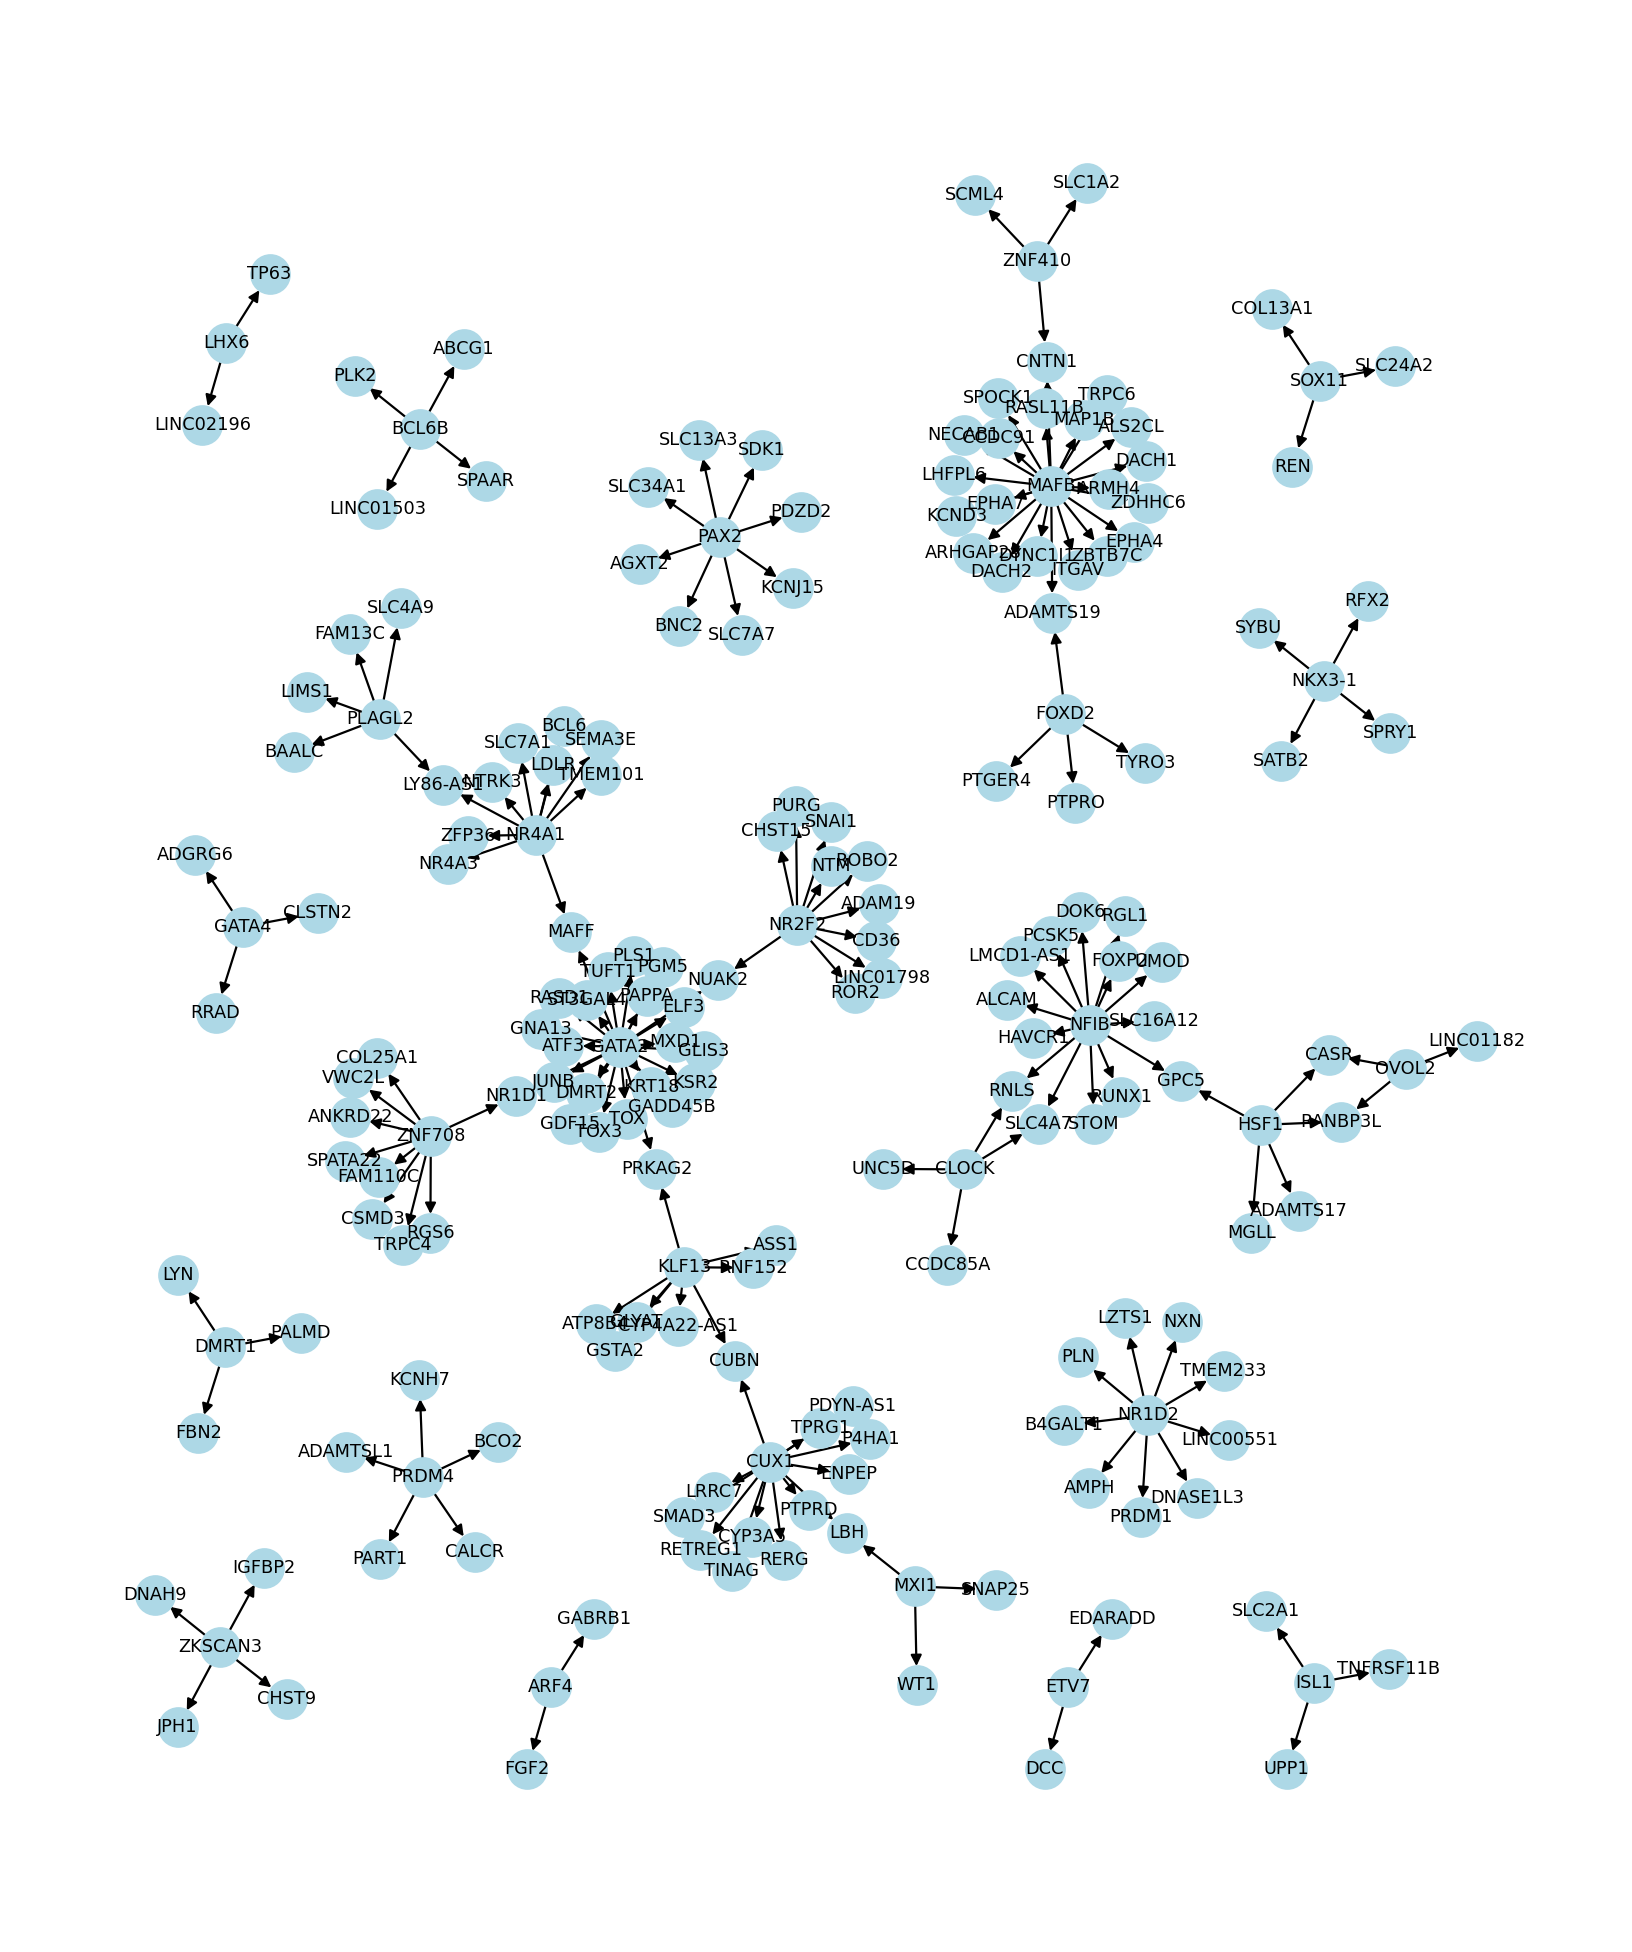

In [51]:
#load and visualize the network
grn = scglue.genomics.read_ctx_grn("drive/MyDrive/work/single_cell_analysis_demo/process/pruned_grn_set1.csv")
rcParams['figure.figsize'] = (10, 12)
nx.draw(grn, 
        graphviz_layout(grn), 
        with_labels=True,
        node_color='lightblue',
        font_size=8)